<a href="https://colab.research.google.com/github/pjjongho/MLOps/blob/main/BANK_MARKETING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MLflow를 활용하여 은행 고객 데이터 분석

**실제 모델 구축 목적**

- 은행 고객 데이터를 분석하여 마케팅을 진행할지 여부를 분석
- 은행의 마케팅 비용을 효율화하고 비용 절감을 목적으로 함.

**Key Pint**

- 데이터를 분석하고 엔지니어링 하는 머신러닝 cycle 과정
- mlflow를 기반으로 모델 최적화 방법
- mlflow를 활용한 model 등록
- mlflow를 활용한 model deploy와 online inference

In [ ]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from datetime import datetime
import random

# library for statistic

from scipy import stats
from scipy.stats import chi2_contingency, kruskal
from scipy.stats import boxcox, norm
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

# library for sampling
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE

# library for machine learning

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, RocCurveDisplay, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve


import shap

##### Data Load

In [ ]:
path = os.listdir()
random_state = 1234

In [ ]:
df = pd.read_csv(path[1] + '/bank-additional-full.csv', sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### 1. $Data$ $Processing 1$

In [ ]:
# Data 의 오류를 사전에 파악하기 위함.

print(f'Duplicated data : {len(df[df.duplicated()])}')

Duplicated data : 12


In [ ]:
df[df.duplicated()]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
20216,55,services,married,high.school,unknown,no,no,cellular,aug,mon,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
20534,41,technician,married,professional.course,no,yes,no,cellular,aug,tue,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no
25217,39,admin.,married,university.degree,no,no,no,cellular,nov,tue,...,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,no
28477,24,services,single,high.school,no,yes,no,cellular,apr,tue,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.423,5099.1,no
32516,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,...,4,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no


In [ ]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null  floa

In [ ]:
# duplicated 된 비어있는 index가 있을수도 있음. -> 해당 index를 제거해야함

df = df.reset_index(drop=True)

### 2. $Data$ $EDA$

#### 2-1. Data Type and Summary

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41176 entries, 0 to 41175
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null 

In [ ]:
# categorical and numeric columns

for column_name in list(df.columns):
    print(f'{column_name} // {df[column_name].dtype} // {df[column_name].unique()}')

age // int64 // [56 57 37 40 45 59 41 24 25 29 35 54 46 50 39 30 55 49 34 52 58 32 38 44
 42 60 53 47 51 48 33 31 43 36 28 27 26 22 23 20 21 61 19 18 70 66 76 67
 73 88 95 77 68 75 63 80 62 65 72 82 64 71 69 78 85 79 83 81 74 17 87 91
 86 98 94 84 92 89]
job // object // ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
marital // object // ['married' 'single' 'divorced' 'unknown']
education // object // ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
default // object // ['no' 'unknown' 'yes']
housing // object // ['no' 'yes' 'unknown']
loan // object // ['no' 'yes' 'unknown']
contact // object // ['telephone' 'cellular']
month // object // ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
day_of_week // object // ['mon' 'tue' 'wed' 'thu' 'fri']
duration // int64 // [ 261  149  226 ... 1246 1556 1868]
campaig

In [ ]:
list_categorical_columns = list(df.select_dtypes(include=['object']).columns)
list_numerical_columns = list(df.select_dtypes(include=['float64','int64']).columns)

print(len(df))
print(len(df.columns))
print(len(list_categorical_columns))
print(len(list_numerical_columns))

41176
21
11
10


In [ ]:
target_column = 'y'

In [ ]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

### 2-2. Dependent Data Explore

In [ ]:
list_categorical_columns.remove(target_column)

In [ ]:
df[target_column].describe()

count     41176
unique        2
top          no
freq      36537
Name: y, dtype: object

In [ ]:
df[target_column].value_counts()

y
no     36537
yes     4639
Name: count, dtype: int64

<Axes: xlabel='y', ylabel='count'>

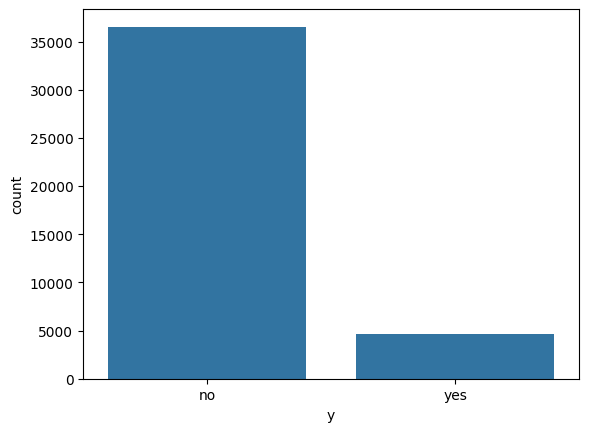

In [ ]:
sns.countplot(x=target_column, data=df)

Imbalance data set

- 두 개 target class 비중 차이가 있음.
- sampling과 cost-sensitive learning으로 문제 해결할 수 있음.
- "Yes" 속성인 데이터들이 유의미한 데이터 분포와 특성을 갖는다면, 추가적인 sampling 없이 모델 학습이 잘 될 수 있다.
- 독립 변수가 categorical 이포함된 경우는 one-hot encoding을 진행한 뒤에 sampling(over-sampling or under-sampling)

##### **1. 데이터 기반 접근 방법**

- Sampling (Over-sampling or Under-Sampling)

##### **2. ML 알고리즘 기반 접근 방법**

- ML 알고리즘 활용 -> ML 학습 시에 class weight를 활용하여 cost-sensitive learning

### 2-3. Independent Data Explore

1) Categorical Data Analysis
    
    - 불필요한 컬럼 확인

In [ ]:
df[list_categorical_columns].nunique().sort_values()

contact         2
default         3
housing         3
loan            3
poutcome        3
marital         4
day_of_week     5
education       8
month          10
job            12
dtype: int64

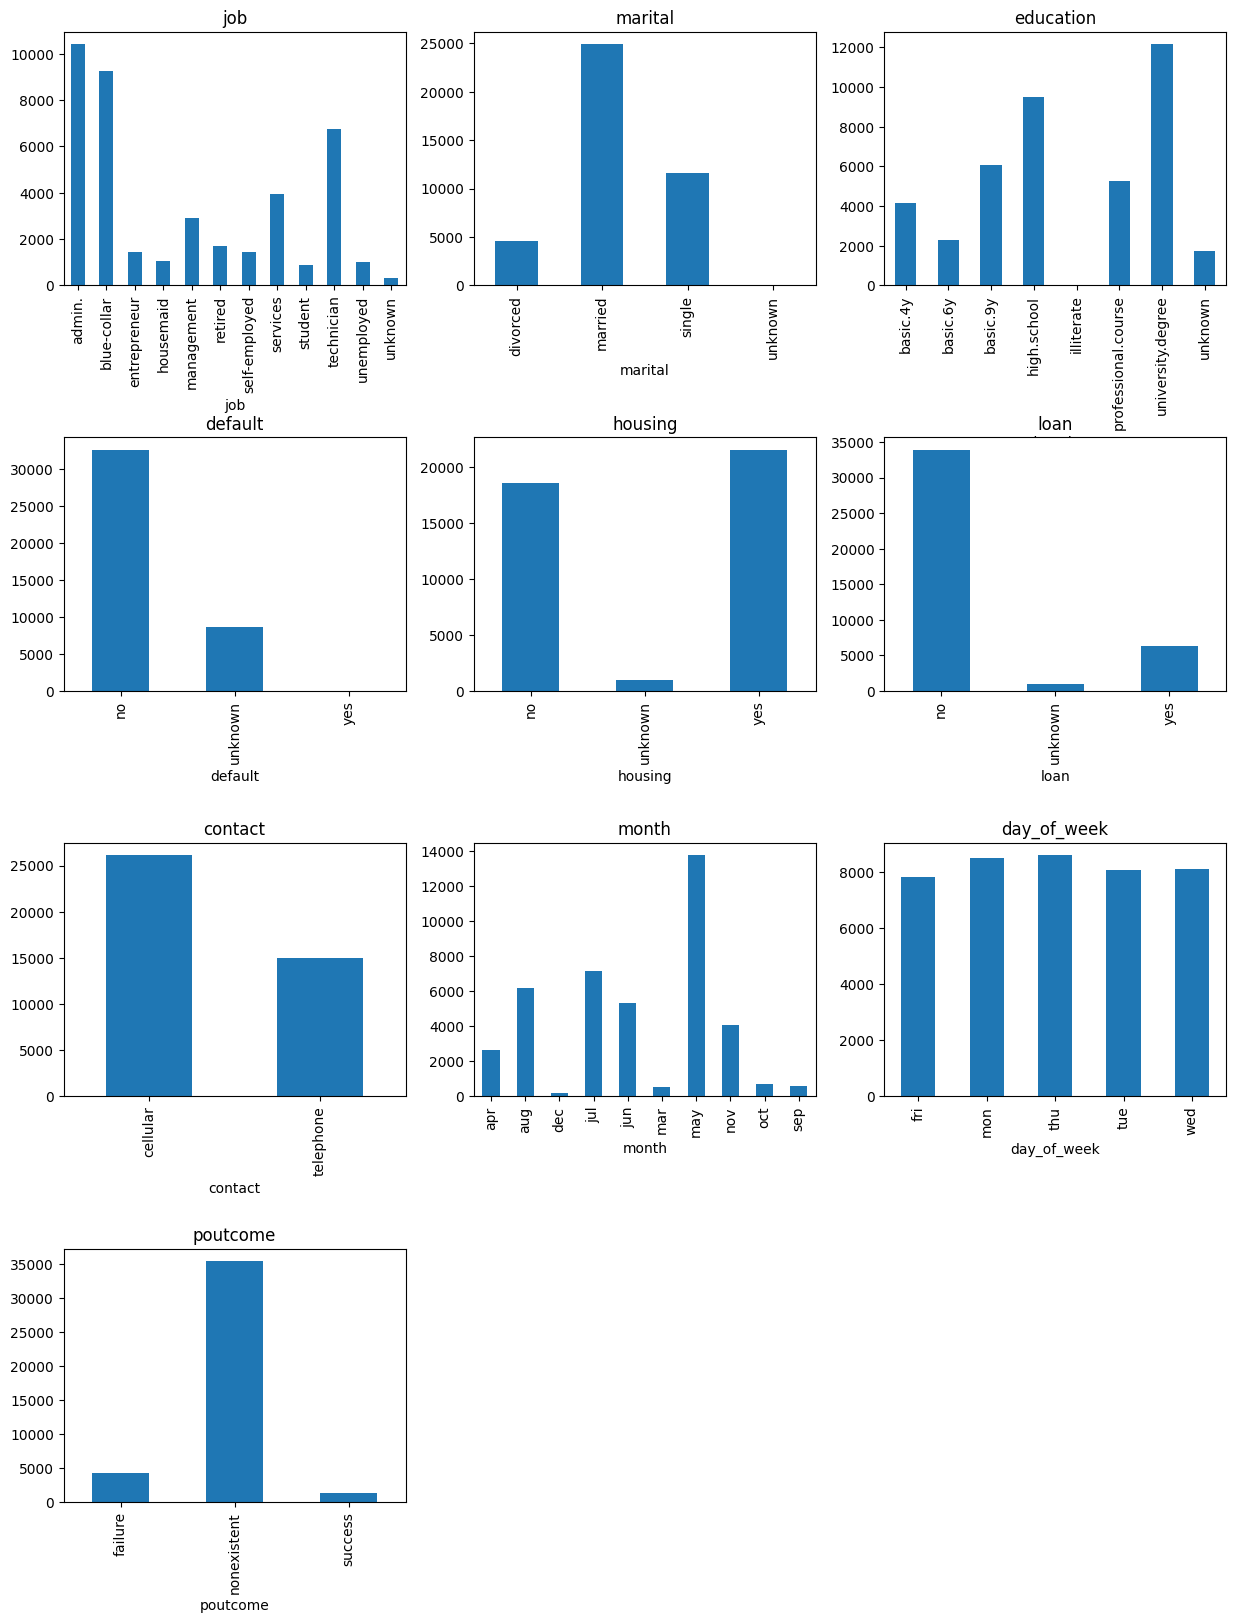

In [ ]:
# categorical column 별 분포 확인

plt.figure(figsize=(15,15))
x=1
plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.6, wspace=0.2)

for column_name in list_categorical_columns:
    plt.subplot(4,3,x)
    x += 1
    df[column_name].value_counts().sort_index().plot(kind='bar')
    plt.title(column_name)

plt.show()

In [ ]:
df[list_categorical_columns[-1]].value_counts()

poutcome
nonexistent    35551
failure         4252
success         1373
Name: count, dtype: int64

<Axes: xlabel='y'>

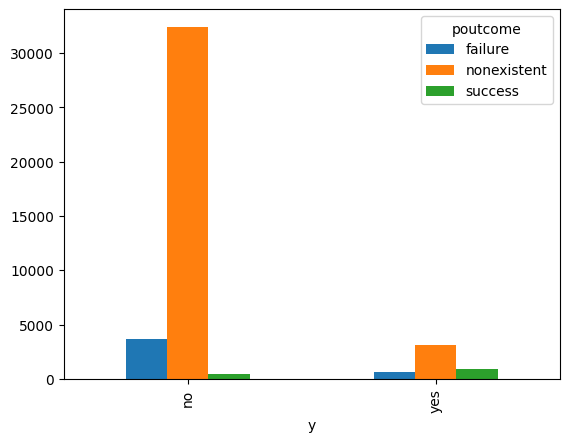

In [ ]:
df_poutcome_dependent = pd.crosstab(df[target_column], df[list_categorical_columns[-1]])
df_poutcome_dependent.plot(kind='bar')

# 애초에 target column 비중의 차이가 크기 때문에, count를 비교하는 것은 데이터 분포를 파악하는데 적합하지 않음

In [ ]:
# 위의 count는 불필요하기 때문에 다음과 같은 table 생성 (비율로 파악)
pd.crosstab(df[target_column], df[list_categorical_columns[-1]], normalize="index")

poutcome,failure,nonexistent,success
y,,,
no,0.099817,0.887073,0.013110
yes,0.130416,0.676870,0.192714


<Axes: xlabel='y'>

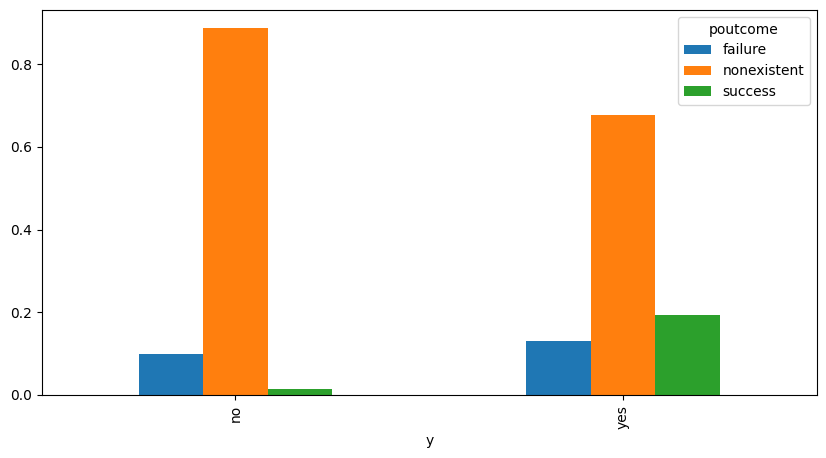

In [ ]:
df_poutcome_dependent_ratio = pd.crosstab(df[target_column], df[list_categorical_columns[-1]], normalize="index")
df_poutcome_dependent_ratio.plot.bar(figsize=(10,5))

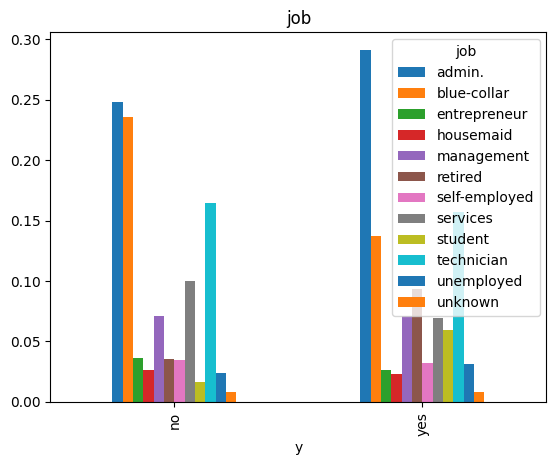

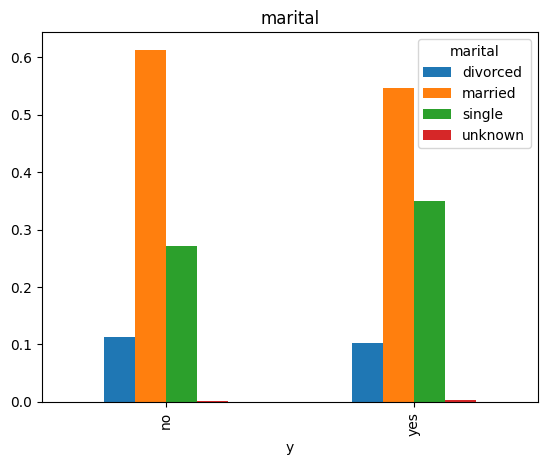

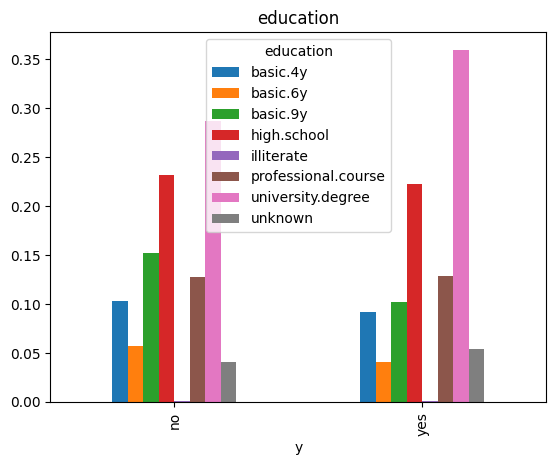

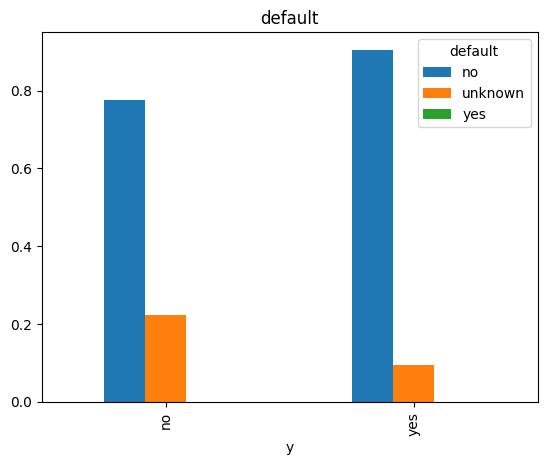

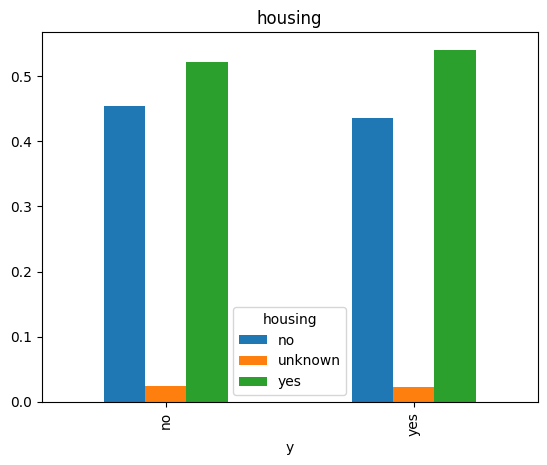

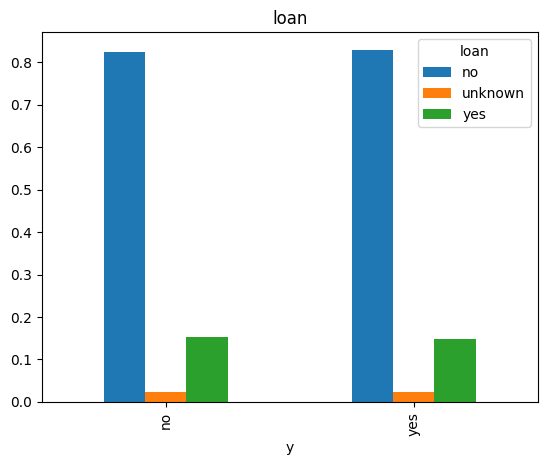

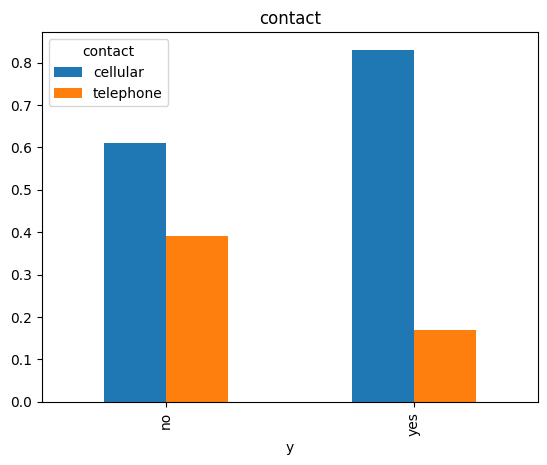

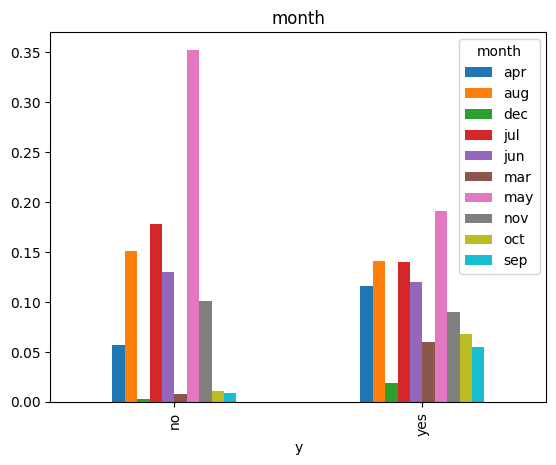

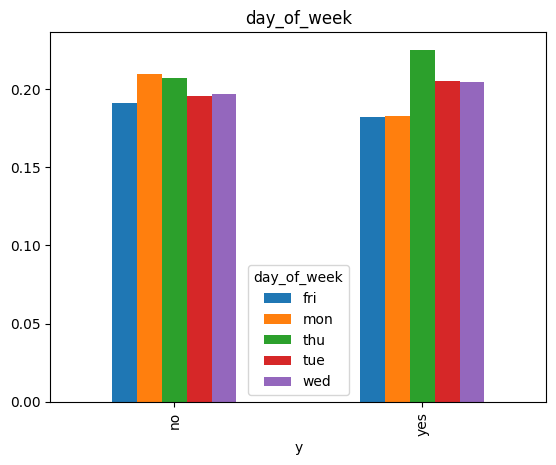

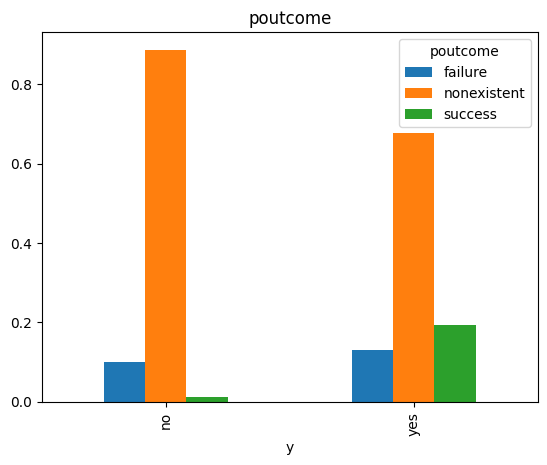

In [ ]:
for column_name in list_categorical_columns:
    pd.crosstab(df[target_column], df[column_name], normalize="index").plot.bar()
    plt.title(column_name)
plt.show()

### $Chi-Square$ $test$

- 카이제곱 검정은 두 범주형 변수에 대한 분석 방법
- ex) 성별에 따른 선호 영화 장르 비교 문제
- 독립 변수중의 categorical column data와 y(marketing 여부) 간의 관계 검증
- p-value가 0.05 이하인 경우 귀무가설을 기각

### $Chi-Square$ $test$ $3가지$ $유형$

**1. 적합도 검정(Goodness of fit)**

- 변수 1개
- 기존에 알려준 기준이 존재하는지 확인하는 검정
- ex) 상자 안에 공 3개가 같은 비율로 알려져 있음. 공 100개를 뽑았을 때, 각 색의 비율이 구해짐 -> 기존에 알려진 공 비율 분포를 따르는지 검정
- 귀무가설 : 변수 X의 관측분포와 기대분포가 동일할 것이다.
- 대립가설 : 변수 X의 관측분포와 기대분포가 동일하지 않을 것이다.

**2. 독립성 검정 (Test of independence)**

- 변수 2개
- 범주형 두 변수가 서로 연관되어 있는지 여부를 검정
- ex) 성별과 흡연 연부 관계를 알고 싶어 200명을 추출하여 조사한 경우
- 귀무가설 : 변수 X와 Y는 서로 독립
- 대립가설 : 변수 X와 Y는 서로 독립이 아니다.

**3. 동질성 검정 (Test of Homogeneity)**

- 변수 2개
- 범주형 두 변수의 관계를 알기위한 검정은 아님
- 각 그룹들이 동질한지 확인하기 위한 검정
- ex) 남자와 여자 흡연율 차이가 있는지 흡연율을 조사한 후, 두 그룹의 흡연율이 같은지 여부를 결정
- 귀무가설 : 각 그룹의 확률분포가 동일
- 대립가설 : 각 그룹의 확률분포가 동일하지 않음

In [ ]:
# Chi-Square Test code

list_meaningful_column_by_chi = []

for column_name in list_categorical_columns:
    statistic, pvalue, _, _ =chi2_contingency(pd.crosstab(df[target_column], df[column_name]))
    if pvalue <= 0.05:
        list_meaningful_column_by_chi.append(column_name)

    print(column_name, statistic, pvalue)

print(f'all categorical columns : {len(list_categorical_columns)}')
print(f'selected columns by chi : {len(list_meaningful_column_by_chi), list_meaningful_column_by_chi}')

job 961.7438037353177 3.2684116066165443e-199
marital 122.95931379226256 1.778422500461116e-26
education 192.8485047401879 3.746768377534744e-38
default 406.5560941574606 5.217540893727963e-89
housing 5.742152842222754 0.05663792749452546
loan 1.0992950447716308 0.5771532081176227
contact 862.0807365848323 1.7187406241263767e-189
month 3103.032672105299 0.0
day_of_week 26.054243692750852 3.085754965631736e-05
poutcome 4230.14342770359 0.0
all categorical columns : 10
selected columns by chi : (8, ['job', 'marital', 'education', 'default', 'contact', 'month', 'day_of_week', 'poutcome'])


$Insight$

1. y(종속변수)와 categorical data 10개 중 8개만이 유의미한 관계를 갖음
2. housing과 loan는 y와 교호작용이 없음
3. 유의미한 관계를 갖는 categorical data를 feature selection하여 추후 Machine Learning에 사용

#### 2) Numeric Data Analysis

불필요한 컬럼 확인

In [ ]:
df[list_numerical_columns].nunique().sort_values()

previous             8
emp.var.rate        10
nr.employed         11
cons.price.idx      26
cons.conf.idx       26
pdays               27
campaign            42
age                 78
euribor3m          316
duration          1544
dtype: int64

In [ ]:
df[list_numerical_columns].describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Column 별 분포 확인

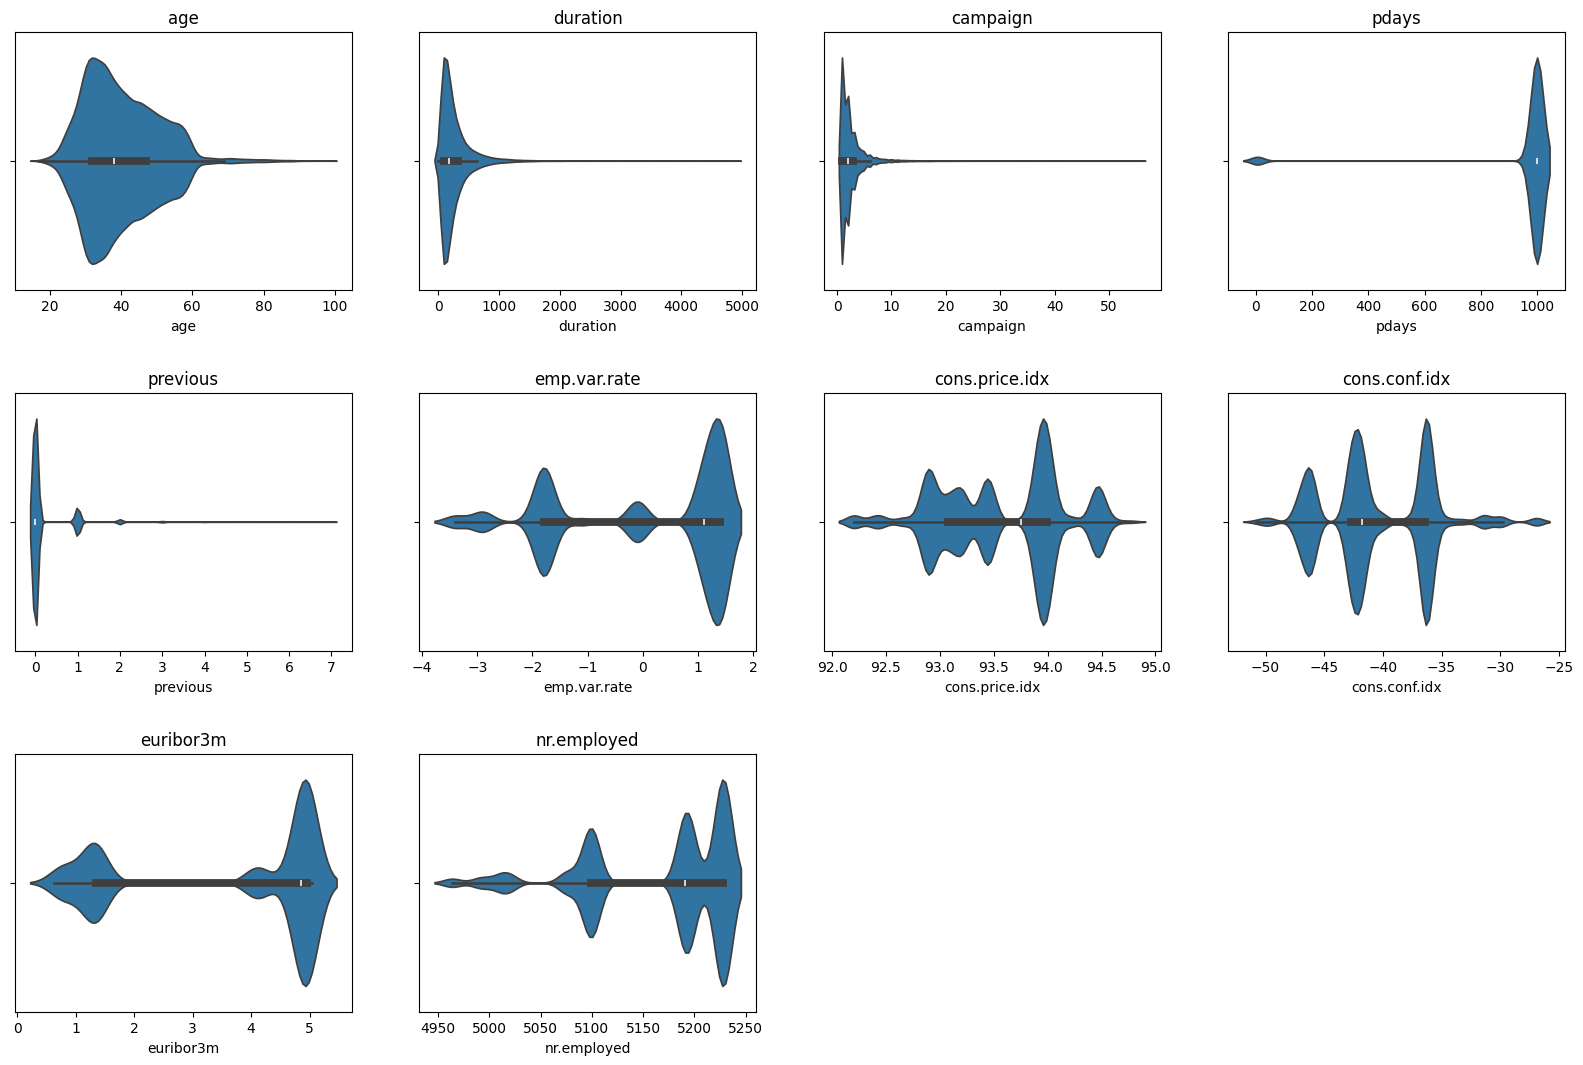

In [ ]:
plt.figure(figsize=(20,10))
x=1

plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.4, wspace=0.2)
for column_name in list_numerical_columns:
    plt.subplot(3,4,x)
    x += 1
    sns.violinplot(x=column_name, data=df)
    plt.title(column_name)
plt.show()

In [ ]:
for column_name in list_numerical_columns:
    print(f'{column_name}, skew : {skew(df[column_name])}, kur : {kurtosis(df[column_name])}')

# 추후 scaling을 활용한 feature preprocessing의 필요성 확인

age, skew : 0.7845316793906337, kur : 0.7908715485573286
duration, skew : 3.2626886475171046, kur : 20.241167105999835
campaign, skew : 4.76187058291751, kur : 36.96722235388976
pdays, skew : -4.921207099141221, kur : 22.21870880664178
previous, skew : 3.8312559388497256, kur : 20.09957712427588
emp.var.rate, skew : -0.7240342146771608, kur : -1.062714697365619
cons.price.idx, skew : -0.2308444969439891, kur : -0.8298960161833482
cons.conf.idx, skew : 0.3028649665515025, kur : -0.3591991612497849
euribor3m, skew : -0.7091683770703301, kur : -1.4067662115952242
nr.employed, skew : -1.0442790133772375, kur : -0.0036849526898108387


Correlation Analysis

In [ ]:
df_corr = df[list_numerical_columns].corr()

<Axes: >

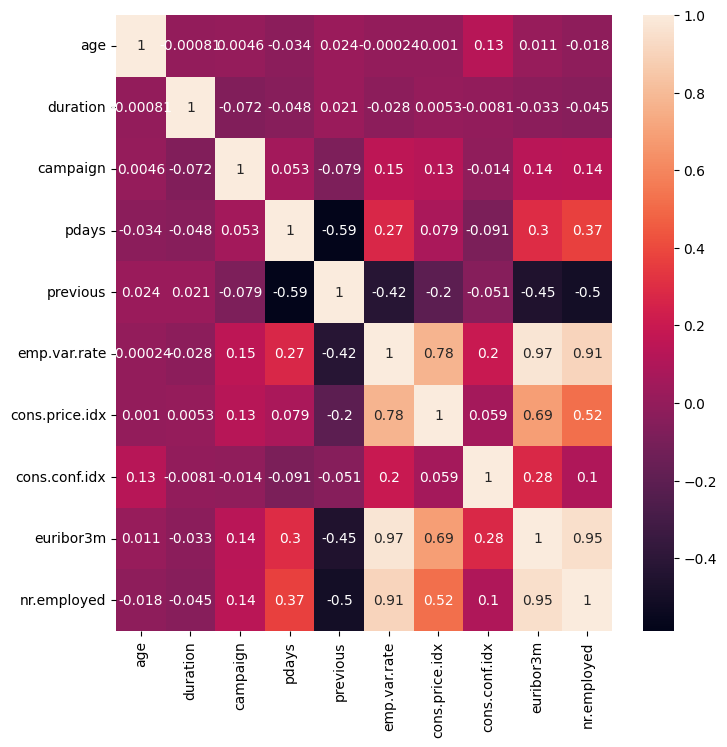

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(df_corr, annot=True)

In [ ]:
# euribor3m 과 emp.var.rate 의 상관관계가 높음 0.97
# nr.employed와 emp.var.rate 의 상관관계가 높음 0.91
# emp.var.rate와 cons.prcie.idx 상관관계가 높음 0.78
# 그 외에도 상관관계 높은 것들이 존재함

# 너무 높은 correlation을 갖는 Data를 삭제. 단, 해당 correlation값을 신뢰할 수 있는지 확인이 필요함
# 기준은 절대값 0.75 이상

index_corr_over = np.where((abs(df_corr)>0.75) & (df_corr != 1))
index_corr_over

(array([5, 5, 5, 6, 8, 8, 9, 9], dtype=int64),
 array([6, 8, 9, 5, 5, 9, 5, 8], dtype=int64))

In [ ]:
len_corr_over = len(index_corr_over[0])
left_columns = df_corr.columns[index_corr_over[0]]
right_columns = df_corr.columns[index_corr_over[1]]

for index in range(len_corr_over):
    print(left_columns[index], "<->", right_columns[index])

emp.var.rate <-> cons.price.idx
emp.var.rate <-> euribor3m
emp.var.rate <-> nr.employed
cons.price.idx <-> emp.var.rate
euribor3m <-> emp.var.rate
euribor3m <-> nr.employed
nr.employed <-> emp.var.rate
nr.employed <-> euribor3m


In [ ]:
# correlation이 0.9 이상인 경우의 pvalue test

list_not_valid = []

for index in range(len_corr_over):
    statistic, pvalue = stats.pearsonr(df.loc[:, left_columns[index]], df.loc[:,right_columns[index]])
    print("%s<->%s : %f %f"%(left_columns[index], right_columns[index], statistic, pvalue))

    if (pvalue > 0.05):
        list_not_valid.append(column_name)

print("end")
print(len(list_not_valid), " is not valids")

emp.var.rate<->cons.price.idx : 0.775293 0.000000
emp.var.rate<->euribor3m : 0.972244 0.000000
emp.var.rate<->nr.employed : 0.906949 0.000000
cons.price.idx<->emp.var.rate : 0.775293 0.000000
euribor3m<->emp.var.rate : 0.972244 0.000000
euribor3m<->nr.employed : 0.945146 0.000000
nr.employed<->emp.var.rate : 0.906949 0.000000
nr.employed<->euribor3m : 0.945146 0.000000
end
0  is not valids


In [ ]:
list_removed_by_correlation = ["emp.var.rate", "euribor3m"]

Target Column과 Numeric Column 관계 분포 확인

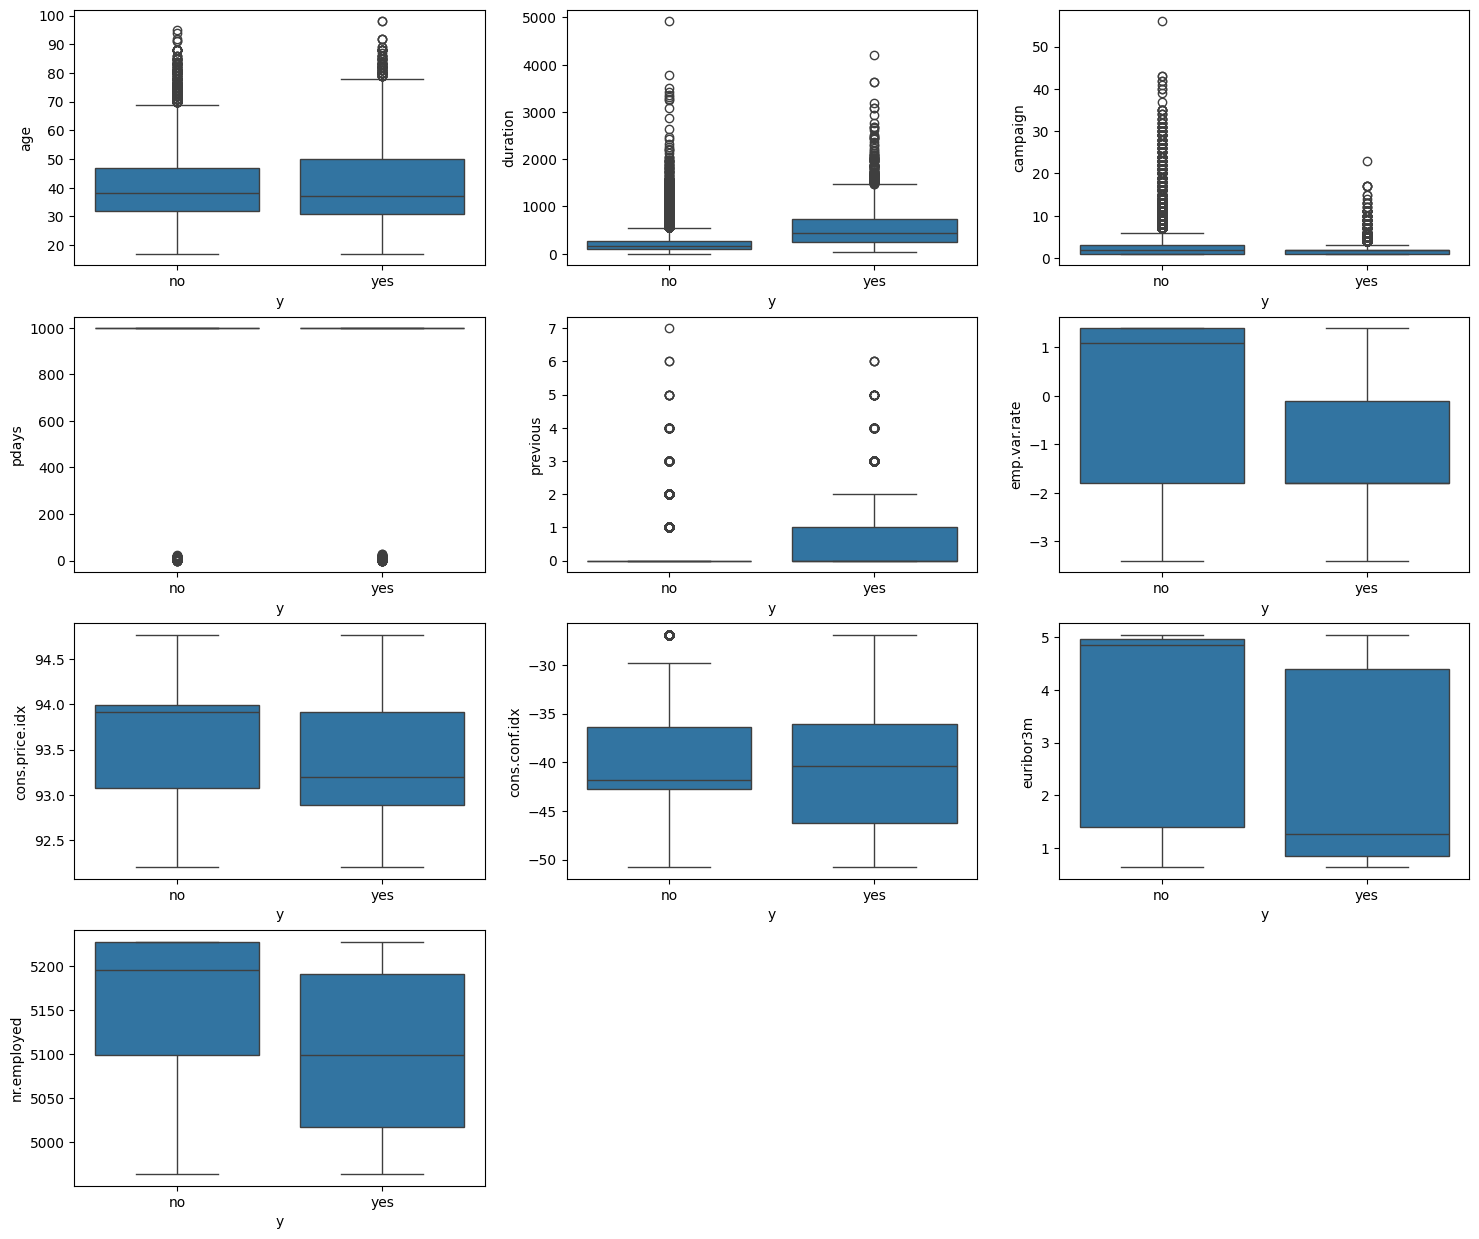

In [ ]:
plt.figure(figsize=(18,12))
x=1
plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.2, wspace=0.2)

for column_name in list_numerical_columns:
    plt.subplot(4,3,x)
    x += 1
    sns.boxplot(data=df, x=target_column, y=column_name)

plt.show()

$일원분산분석$ $(ANOVA)$

- 카테고리별 numeric data 분포 차이 검증
- 전제 : 정규성, 등분산성, 독립성 (만족하지 않으면 해당 검정을 신뢰할 수 없음)
- y에 따른 numeric column data 분포 관계 검증
- pvalue <= 0.05 인 경우 귀무가설 기각

$정규성$ $검정$

- 귀무가설 : 모집단의 분포는 정규 분포
- 검정방법 : qqplot, Shapiro-Wilks Test
- p-value < 0.05 이면, 귀무가설 기각(기각하지 못하여야 정규성을 만족함)

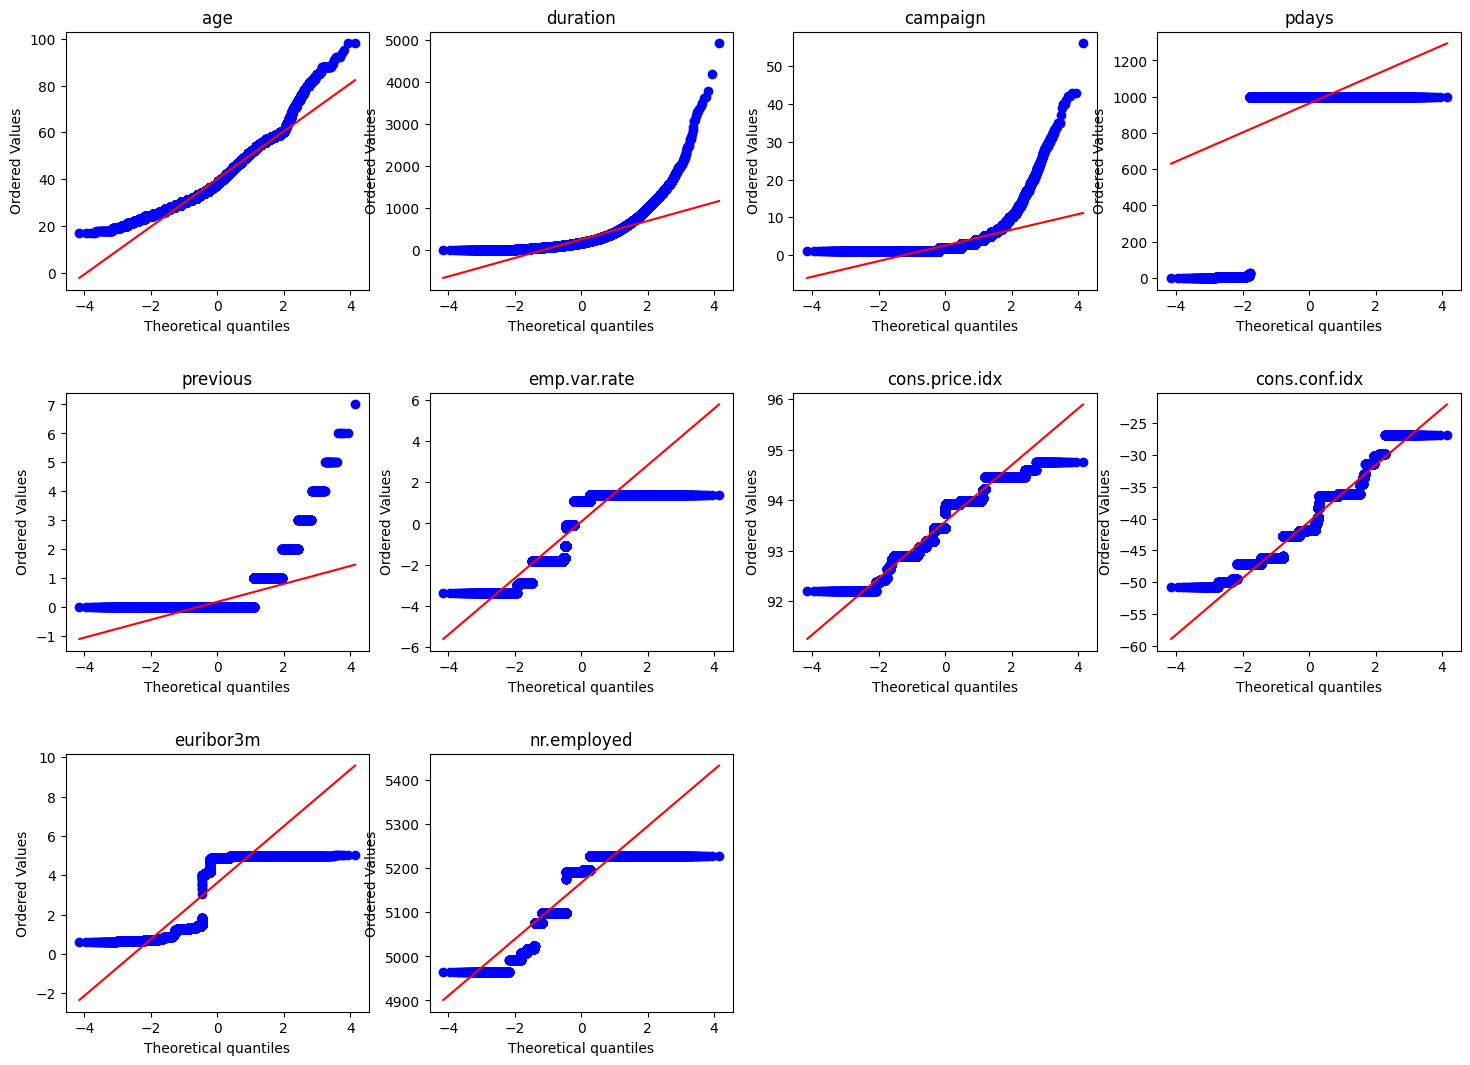

In [ ]:
plt.figure(figsize=(18,10))
x=1
plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.4, wspace=0.2)

for column_name in list_numerical_columns:
    plt.subplot(3,4,x)
    x += 1

    stats.probplot(df[column_name], dist=stats.norm, plot=plt)

    plt.title(column_name)

plt.show()

In [ ]:
list_column_normality = []

for column_name in list_numerical_columns:
    statistic, pvalue = stats.shapiro(df[column_name])
    if pvalue > 0.05:
        list_column_normality.append(column_name)

    print(f'{column_name}, statistic : {statistic}, pvalue : {pvalue}')

print(f'정규성을 만족하는 columns : {len(list_column_normality)}')
print(list_column_normality)

age, statistic : 0.9572796821594238, pvalue : 0.0
duration, statistic : 0.7216830849647522, pvalue : 0.0
campaign, statistic : 0.5578689575195312, pvalue : 0.0
pdays, statistic : 0.1829797625541687, pvalue : 0.0
previous, statistic : 0.39130860567092896, pvalue : 0.0
emp.var.rate, statistic : 0.7621634006500244, pvalue : 0.0
cons.price.idx, statistic : 0.933931827545166, pvalue : 0.0
cons.conf.idx, statistic : 0.9238575100898743, pvalue : 0.0
euribor3m, statistic : 0.6863111853599548, pvalue : 0.0
nr.employed, statistic : 0.7877941727638245, pvalue : 0.0
정규성을 만족하는 columns : 0
[]


p-value may not be accurate for N > 5000.


$Insight$

정규성을 만족하지 못함

- 정규성을 만족하지 못하므로, 등분산성 검정이 필요가 없음 (등분산성은 정규성을 전제로 하기 때문)
- 일원분산분석을 통한 numeric data 검정 불가

크루스칼 왈리스 검정 Kruskall-Wallis Test (비모수 검정)

- 비모수 검정이기 때문에 정규성/등분산성을 만족하지 않아도 된다.
- 단, 비모수 검정이기 때문에 검정 결과 신뢰도가 모수 검정보다 떨어짐

In [ ]:
list_meaningful_column_by_kruskall = []

list_target_unique = df[target_column].unique()

for column_name in list_numerical_columns:
    list_by_target_value = []

    for target_value in list_target_unique:
        df_tmp = df[df[target_column] == target_value][column_name].dropna()
        list_by_target_value.append(np.array(df_tmp))

    statistic, pvalue = kruskal(*list_by_target_value)
    if pvalue <= 0.05:
        list_meaningful_column_by_kruskall.append(column_name)

    print(f'{column_name}, {statistic}, {pvalue}')

print(f'all numeric columns : {len(list_numerical_columns)}')
print(f'selected columns by kruskall : {len(list_meaningful_column_by_kruskall), list_meaningful_column_by_kruskall}')

age, 5.843156420996497, 0.015637749222475184
duration, 5008.952641567334, 0.0
campaign, 166.83794105975488, 3.629350163987945e-38
pdays, 4348.437887965406, 0.0
previous, 1662.3956401363578, 0.0
emp.var.rate, 2520.7461098911913, 0.0
cons.price.idx, 614.0899232769726, 1.4427370342045907e-135
cons.conf.idx, 69.64459433834713, 7.101309014386373e-17
euribor3m, 2930.314757187436, 0.0
nr.employed, 3318.9556210068745, 0.0
all numeric columns : 10
selected columns by kruskall : (10, ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'])


$Insight$

1. y(종속변수)와 numerical data는 모두 유의미한 관계를 갖음(크루스칼 왈리스 검정)
2. 상관관계가 매우 높은 변수들이 존재하며 2개 데이터를 제거 예정("emp.var.rate", "euribor3m")

### 3. $Data$ $Processing2$

#### 3-1. Missing Values

In [ ]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

#### 3-2. Missing Values

- 카이제곱 검정을 통과한 categorical selection
- kruskall 검정 통과한  numerical 선택
- correlation 에서 상관관계가 높다고 판단한 numerical data 제거

In [ ]:
list_selected_numerical = list_meaningful_column_by_kruskall.copy()
for column_name in list_removed_by_correlation:
    list_selected_numerical.remove(column_name)

In [ ]:
df_fs = df[list_meaningful_column_by_chi + list_selected_numerical +[target_column]]
df_fs.head()

,job,marital,education,default,contact,month,day_of_week,poutcome,age,duration,campaign,pdays,previous,cons.price.idx,cons.conf.idx,nr.employed,y
0,housemaid,married,basic.4y,no,telephone,may,mon,nonexistent,56,261,1,999,0,93.994,-36.4,5191.0,no
1,services,married,high.school,unknown,telephone,may,mon,nonexistent,57,149,1,999,0,93.994,-36.4,5191.0,no
2,services,married,high.school,no,telephone,may,mon,nonexistent,37,226,1,999,0,93.994,-36.4,5191.0,no
3,admin.,married,basic.6y,no,telephone,may,mon,nonexistent,40,151,1,999,0,93.994,-36.4,5191.0,no
4,services,married,high.school,no,telephone,may,mon,nonexistent,56,307,1,999,0,93.994,-36.4,5191.0,no


#### 3-3. Feature Transformation

In [ ]:
Y = df_fs[target_column]
X = df_fs.drop([target_column], axis=1)

In [ ]:
le = LabelEncoder()
le.fit(Y)
Y_encoded = le.transform(Y)

In [ ]:
Y_encoded

array([0, 0, 0, ..., 0, 1, 0])

Feature Scaling

- Standardization and MinMaxScaling

In [ ]:
list_categorical_columns = list(df_fs.select_dtypes(include=['object']).columns)
list_numerical_columns = list(df_fs.select_dtypes(include=['float64','int64']).columns)

print(len(list_categorical_columns))
print(len(list_numerical_columns))

9
8


In [ ]:
scaler = MinMaxScaler()
X.loc[:, list_numerical_columns] = scaler.fit_transform(X[list_numerical_columns])
X.head()

,job,marital,education,default,contact,month,day_of_week,poutcome,age,duration,campaign,pdays,previous,cons.price.idx,cons.conf.idx,nr.employed
0,housemaid,married,basic.4y,no,telephone,may,mon,nonexistent,0.481481,0.053070,0.0,1.0,0.0,0.698753,0.60251,0.859735
1,services,married,high.school,unknown,telephone,may,mon,nonexistent,0.493827,0.030297,0.0,1.0,0.0,0.698753,0.60251,0.859735
2,services,married,high.school,no,telephone,may,mon,nonexistent,0.246914,0.045954,0.0,1.0,0.0,0.698753,0.60251,0.859735
3,admin.,married,basic.6y,no,telephone,may,mon,nonexistent,0.283951,0.030704,0.0,1.0,0.0,0.698753,0.60251,0.859735
4,services,married,high.school,no,telephone,may,mon,nonexistent,0.481481,0.062424,0.0,1.0,0.0,0.698753,0.60251,0.859735


One-hot Encoding for categorical column data

In [ ]:
X_base = pd.get_dummies(X)
X_base.head()

,age,duration,campaign,pdays,previous,cons.price.idx,cons.conf.idx,nr.employed,job_admin.,job_blue-collar,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0.481481,0.053070,0.0,1.0,0.0,0.698753,0.60251,0.859735,False,False,...,False,False,False,True,False,False,False,False,True,False
1,0.493827,0.030297,0.0,1.0,0.0,0.698753,0.60251,0.859735,False,False,...,False,False,False,True,False,False,False,False,True,False
2,0.246914,0.045954,0.0,1.0,0.0,0.698753,0.60251,0.859735,False,False,...,False,False,False,True,False,False,False,False,True,False
3,0.283951,0.030704,0.0,1.0,0.0,0.698753,0.60251,0.859735,True,False,...,False,False,False,True,False,False,False,False,True,False
4,0.481481,0.062424,0.0,1.0,0.0,0.698753,0.60251,0.859735,False,False,...,False,False,False,True,False,False,False,False,True,False


In [ ]:
X_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41176 entries, 0 to 41175
Data columns (total 55 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41176 non-null  float64
 1   duration                       41176 non-null  float64
 2   campaign                       41176 non-null  float64
 3   pdays                          41176 non-null  float64
 4   previous                       41176 non-null  float64
 5   cons.price.idx                 41176 non-null  float64
 6   cons.conf.idx                  41176 non-null  float64
 7   nr.employed                    41176 non-null  float64
 8   job_admin.                     41176 non-null  bool   
 9   job_blue-collar                41176 non-null  bool   
 10  job_entrepreneur               41176 non-null  bool   
 11  job_housemaid                  41176 non-null  bool   
 12  job_management                 41176 non-null 

In [ ]:
X_base.iloc[:,8:] = X_base.iloc[:,8:].astype(int)

In [ ]:
X_base.head()

,age,duration,campaign,pdays,previous,cons.price.idx,cons.conf.idx,nr.employed,job_admin.,job_blue-collar,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0.481481,0.053070,0.0,1.0,0.0,0.698753,0.60251,0.859735,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0.493827,0.030297,0.0,1.0,0.0,0.698753,0.60251,0.859735,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0.246914,0.045954,0.0,1.0,0.0,0.698753,0.60251,0.859735,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0.283951,0.030704,0.0,1.0,0.0,0.698753,0.60251,0.859735,1,0,...,0,0,0,1,0,0,0,0,1,0
4,0.481481,0.062424,0.0,1.0,0.0,0.698753,0.60251,0.859735,0,0,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X_base, Y_encoded, test_size=0.2, stratify=Y_encoded)

### 4. $Model$ $Optimization$

set mlflow

In [ ]:
import mlflow

In [ ]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [ ]:
mlflow.create_experiment("bank_marketing_pracitce")

'624029506736469343'

In [ ]:
mlflow.set_experiment("bank_marketing_pracitce")

<Experiment: artifact_location='mlflow-artifacts:/624029506736469343', creation_time=1734924960703, experiment_id='624029506736469343', last_update_time=1734924960703, lifecycle_stage='active', name='bank_marketing_pracitce', tags={}>

#### 4-1. Base Model without sampling

In [ ]:
# mlflow logging and Model Training
# StratifiedKFold -> train dataset을 여러개로 분할한 뒤에 / 각각의 데이터를 활용해서 model을 여러개 학습시킨 뒤 -> 최종 결과를 판단하고 모델 저장

with mlflow.start_run():
    n_split = 3
    skf = StratifiedKFold(n_splits=n_split)
    skf.get_n_splits(X_base, Y_encoded)

    list_fold_result_test = []
    list_fold_result_validation = []
    list_fold_roc_test = []
    list_fold_roc_validation = []

    num_hidden_layer_sizes = 10
    activation = "relu"
    learning_rate_init = 0.001

    mlflow.log_param("split num", n_split)
    mlflow.log_param("hidden_layer_sized", num_hidden_layer_sizes)
    mlflow.log_param("activation", activation)
    mlflow.log_param("learning_rate_init", learning_rate_init)
    mlflow.log_param("sampling", "None")

    # model training code

    for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
        print("Split" + str(i+1))

        # data setting
        X_train_cv, X_test_cv = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
        y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

        # model setting
        rf_clf = MLPClassifier(hidden_layer_sizes=num_hidden_layer_sizes, activation = activation, learning_rate_init=learning_rate_init)
        rf_clf.fit(X_train_cv, y_train_cv)

        # model inference
        y_prd_test = rf_clf.predict(X_test_cv)
        y_prd_proba_test = rf_clf.predict_proba(X_test_cv)[:, -1]


        # score evaluation on test set
        prf_score_test = precision_recall_fscore_support(y_test_cv, y_prd_test, average="macro")
        score_test = roc_auc_score(y_test_cv, y_prd_proba_test, average="macro")
        list_fold_roc_test.append(score_test)
        list_fold_result_test.append(prf_score_test)

        # model inference on validation set
        y_prd_validation = rf_clf.predict(X_validation)
        y_prd_proba_validation = rf_clf.predict_proba(X_validation)[:,-1]

        # score evaluation on validation set
        prf_score_validation = precision_recall_fscore_support(y_validation, y_prd_validation, average="macro")
        score_validation = roc_auc_score(y_validation, y_prd_proba_validation, average="macro")
        list_fold_roc_validation.append(score_validation)
        list_fold_result_validation.append(prf_score_validation)


    # evaluation code + mlflow logging

    def get_prf_average(list_of_result):
        pre=0
        rec=0
        f1=0

        for result in list_of_result:
            pre += result[0]
            rec += result[1]
            f1 += result[2]

        return pre/n_split, rec/n_split, f1/n_split

    pre, rec, f1 = get_prf_average(list_fold_result_test)
    pre_val, rec_val, f1_val = get_prf_average(list_fold_result_validation)

    roc = sum(list_fold_roc_test)/n_split
    roc_val = sum(list_fold_roc_validation)/n_split

    mlflow.log_metric("precision_on_test", pre)
    mlflow.log_metric("recall_on_test", rec)
    mlflow.log_metric("f1-score_on_test", f1)
    mlflow.log_metric("roc_on_test", roc)
    mlflow.log_metric("precision_on_validation", pre_val)
    mlflow.log_metric("recall_on_validation", rec_val)
    mlflow.log_metric("f1-score_on_validation", f1_val)
    mlflow.log_metric("roc_on_validation", roc_val)


    def save_artifact(model, X_validation, y_validation, y_pred):

        roc_plot = RocCurveDisplay.from_estimator(model, X_validation, y_validation, name = "ML ROC CURVE GRAPH")
        plt.savefig('model_roc_plot.png')
        plt.clf()

        conf_matrix = confusion_matrix(y_validation, y_pred)
        ax = sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='YlGnBu_r')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.title('Confusion Matrix')
        plt.savefig('model_conf_matrix.png')
        plt.clf()

        mlflow.log_artifact('model_roc_plot.png')
        mlflow.log_artifact('model_conf_matrix.png')

    save_artifact(rf_clf, X_validation, y_validation, y_prd_validation)

    mlflow.sklearn.log_model(rf_clf, "model")



mlflow.end_run()

Split1


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


Split2
Split3


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
2024/12/23 13:17:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/23 13:17:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run dazzling-ray-250 at: http://127.0.0.1:5000/#/experiments/624029506736469343/runs/6667bbb5fa9f4e148d9e93a6681bd91d.
2024/12/23 13:17:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/624029506736469343.


<Figure size 640x480 with 0 Axes>

#### 4-2. Sampling

- over-sampling 기법과 combined-sampling 기법 활용, 2 가지로 만들어진 데이터를 활용하여 Model Optimization 진행
- SMOTE Minority class 에서 synthetic sampling을 생성하는 방법. 특정 Minority class A 에서 Knn 기준으로 가까운 minority class Set K를 생성하고, A와 Set K 사이 간에 새로운 관측치를 생성하는 방법
- SMOTEENN : SMOTE + ENN

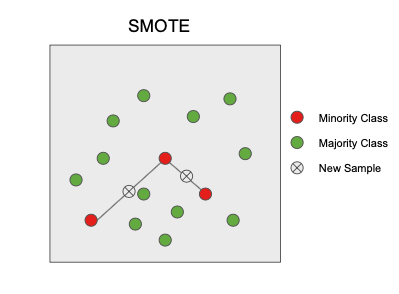

In [ ]:
Image(path[2]+'/SMOTE.png')

SMOTE

In [ ]:
# SMOTE Sampling

sm = SMOTE()
X_sm_sampling, y_sm_sampling = sm.fit_resample(X_train, y_train)

Text(0.5, 1.0, 'After sampling for target label')

<Figure size 640x480 with 0 Axes>

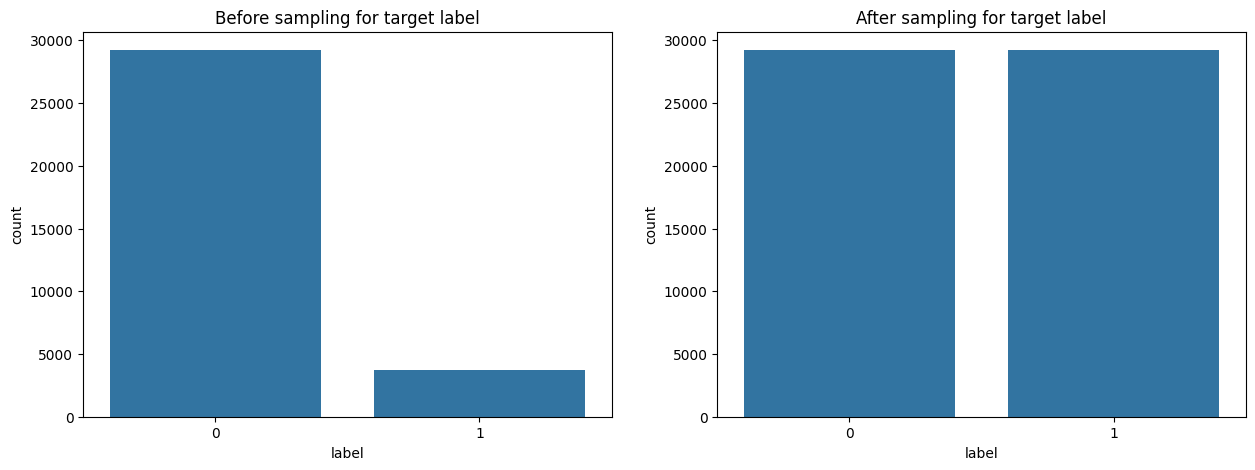

In [ ]:
plt.clf()
fig = plt.figure(figsize=(15,5))
fig.add_subplot(121)
sns.countplot(x="label", data=pd.DataFrame(y_train, columns=['label']))
plt.title('Before sampling for target label')

fig.add_subplot(122)
sns.countplot(x='label', data = pd.DataFrame(y_sm_sampling, columns=['label']))
plt.title("After sampling for target label")

SMOTEENN

In [ ]:
# Combined Sampling

combined_sm = SMOTEENN(random_state=random_state)
X_csm_sampling, y_csm_sampling = combined_sm.fit_resample(X_train, y_train)

Text(0.5, 1.0, 'After sampling for target label')

<Figure size 640x480 with 0 Axes>

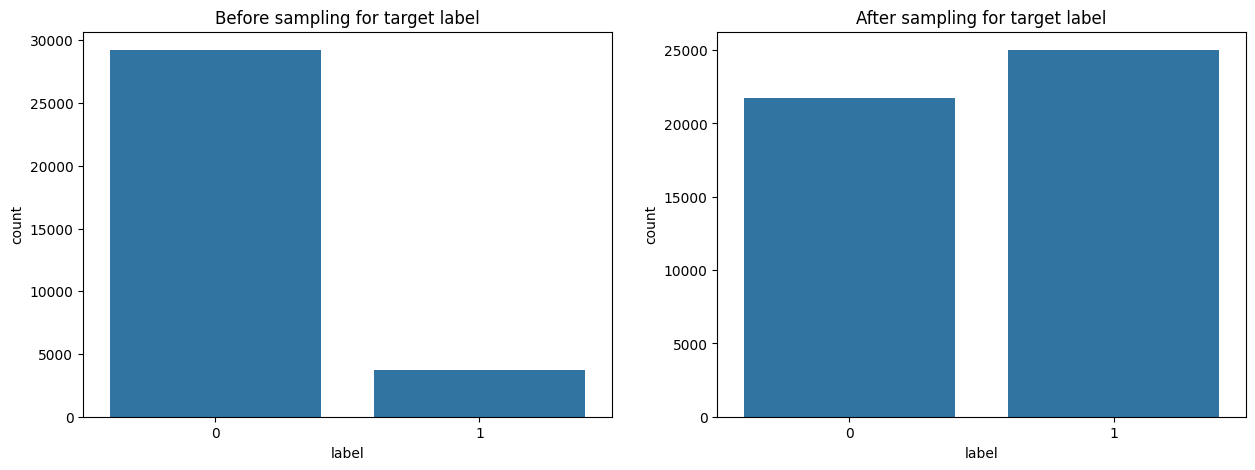

In [ ]:
plt.clf()
fig = plt.figure(figsize=(15,5))
fig.add_subplot(121)
sns.countplot(x="label", data=pd.DataFrame(y_train, columns=['label']))
plt.title('Before sampling for target label')

fig.add_subplot(122)
sns.countplot(x='label', data = pd.DataFrame(y_csm_sampling, columns=['label']))
plt.title("After sampling for target label")

최종 생성 Feature 는 아래와 같은 특성을 지님

1. Feature Selection by Chi-test, correlation and kruskal-test
2. Feature Transformation
3. Sampling(over-sampling, under-sampling)

Feature 종류

1. X_base, Y_encoded(No sampling, imbalanced data)
2. X_sm_sampling, Y_sm_sampling (smote oversampling)
3. X_csm_sampling, y_csm_sampling (smoteenn combined sampling)

#### 4-3. Model Optimization with smote oversampling

In [ ]:
with mlflow.start_run():
    n_split = 3
    skf = StratifiedKFold(n_splits=n_split)
    skf.get_n_splits(X_base, Y_encoded)

    list_fold_result_test = []
    list_fold_result_validation = []
    list_fold_roc_test = []
    list_fold_roc_validation = []
    num_hidden_layer_sizes = 10
    activation = "relu"
    learning_rate_init = 0.001

    mlflow.log_param("split num", n_split)
    mlflow.log_param("hidden_layer_sized", num_hidden_layer_sizes)
    mlflow.log_param("activation", activation)
    mlflow.log_param("learning_rate_init", learning_rate_init)
    mlflow.log_param("sampling", "SMOTE")

    # model training code

    for i, (train_index, test_index) in enumerate(skf.split(X_sm_sampling, y_sm_sampling)):
        print("Split" + str(i+1))

        # data setting
        X_train_cv, X_test_cv = X_sm_sampling.iloc[train_index, :], X_sm_sampling.iloc[test_index, :]
        y_train_cv, y_test_cv = y_sm_sampling[train_index], y_sm_sampling[test_index]

        # model setting
        rf_clf = MLPClassifier(hidden_layer_sizes=num_hidden_layer_sizes, activation = activation, learning_rate_init=learning_rate_init)
        rf_clf.fit(X_train_cv, y_train_cv)

        # model inference
        y_prd_test = rf_clf.predict(X_test_cv)
        y_prd_proba_test = rf_clf.predict_proba(X_test_cv)[:, -1]


        # score evaluation on test set
        prf_score_test = precision_recall_fscore_support(y_test_cv, y_prd_test, average="macro")
        score_test = roc_auc_score(y_test_cv, y_prd_proba_test, average="macro")
        print(i, "precision, recall, f1-score : ", prf_score_test)
        print(i, "roc_auc_score : ", score_test)
        list_fold_roc_test.append(score_test)
        list_fold_result_test.append(prf_score_test)

        # model inference on validation set
        y_prd_validation = rf_clf.predict(X_validation)
        y_prd_proba_validation = rf_clf.predict_proba(X_validation)[:,-1]

        # score evaluation on validation set
        prf_score_validation_macro = precision_recall_fscore_support(y_validation, y_prd_validation, average="macro")
        score_validation = roc_auc_score(y_validation, y_prd_proba_validation, average="macro")
        print("validation : precision, recall, f1-score : ", prf_score_validation_macro)
        print("validation : roc_auc_score : ", score_validation)
        list_fold_roc_validation.append(score_validation)
        list_fold_result_validation.append(prf_score_validation)


    # evaluation code + mlflow logging

    def get_prf_average(list_of_result):
        pre=0
        rec=0
        f1=0

        for result in list_of_result:
            pre += result[0]
            rec += result[1]
            f1 += result[2]

        return pre/n_split, rec/n_split, f1/n_split

    pre, rec, f1 = get_prf_average(list_fold_result_test)
    pre_val, rec_val, f1_val = get_prf_average(list_fold_result_validation)

    roc = sum(list_fold_roc_test)/n_split
    roc_val = sum(list_fold_roc_validation)/n_split

    mlflow.log_metric("precision_on_test", pre)
    mlflow.log_metric("recall_on_test", rec)
    mlflow.log_metric("f1-score_on_test", f1)
    mlflow.log_metric("roc_on_test", roc)
    mlflow.log_metric("precision_on_validation", pre_val)
    mlflow.log_metric("recall_on_validation", rec_val)
    mlflow.log_metric("f1-score_on_validation", f1_val)
    mlflow.log_metric("roc_on_validation", roc_val)


    def save_artifact(model, X_validation, y_validation, y_pred):

        roc_plot = RocCurveDisplay.from_estimator(model, X_validation, y_validation, name = "ML ROC CURVE GRAPH")
        plt.savefig('model_roc_plot.png')
        plt.clf()

        conf_matrix = confusion_matrix(y_validation, y_pred)
        ax = sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='YlGnBu_r')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.title('Confusion Matrix')
        plt.savefig('model_conf_matrix.png')
        plt.clf()

        mlflow.log_artifact('model_roc_plot.png')
        mlflow.log_artifact('model_conf_matrix.png')

    save_artifact(rf_clf, X_validation, y_validation, y_prd_validation)

    mlflow.sklearn.log_model(rf_clf, "model")



mlflow.end_run()

Split1
0 precision, recall, f1-score :  (0.880951377787556, 0.867186698142256, 0.8659760470694076, None)
0 roc_auc_score :  0.9663448544034525
validation : precision, recall, f1-score :  (0.7397211292425048, 0.6874315818281336, 0.7089041276888114, None)
validation : roc_auc_score :  0.9043409265707868
Split2
1 precision, recall, f1-score :  (0.9498269283328857, 0.947603407574669, 0.9475385776065467, None)
1 roc_auc_score :  0.993488636612275
validation : precision, recall, f1-score :  (0.7338407779634211, 0.8191964285714286, 0.7658201022862581, None)
validation : roc_auc_score :  0.9340907401902497
Split3
2 precision, recall, f1-score :  (0.9488919865818919, 0.9462177973930002, 0.9461375785935349, None)
2 roc_auc_score :  0.9934881836280788
validation : precision, recall, f1-score :  (0.7379912508868596, 0.8314432813355227, 0.7722516366974854, None)
validation : roc_auc_score :  0.9349825356718192


2024/12/23 13:37:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/23 13:37:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run gregarious-shark-725 at: http://127.0.0.1:5000/#/experiments/624029506736469343/runs/c6bba05be7674833a677716774121ccf.
2024/12/23 13:37:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/624029506736469343.


<Figure size 640x480 with 0 Axes>

#### 4-5. Model Optimization with smoteenn combined sampling

In [ ]:
with mlflow.start_run():
    n_split = 3
    skf = StratifiedKFold(n_splits=n_split)
    skf.get_n_splits(X_base, Y_encoded)

    list_fold_result_test = []
    list_fold_result_validation = []
    list_fold_roc_test = []
    list_fold_roc_validation = []
    num_hidden_layer_sizes = 10
    activation = "relu"
    learning_rate_init = 0.001

    mlflow.log_param("split num", n_split)
    mlflow.log_param("hidden_layer_sized", num_hidden_layer_sizes)
    mlflow.log_param("activation", activation)
    mlflow.log_param("learning_rate_init", learning_rate_init)
    mlflow.log_param("sampling", "SMOTEENN")

    # model training code

    for i, (train_index, test_index) in enumerate(skf.split(X_csm_sampling, y_csm_sampling)):
        print("Split" + str(i+1))

        # data setting
        X_train_cv, X_test_cv = X_csm_sampling.iloc[train_index, :], X_csm_sampling.iloc[test_index, :]
        y_train_cv, y_test_cv = y_csm_sampling[train_index], y_csm_sampling[test_index]

        # model setting
        rf_clf = MLPClassifier(hidden_layer_sizes=num_hidden_layer_sizes, activation = activation, learning_rate_init=learning_rate_init)
        rf_clf.fit(X_train_cv, y_train_cv)

        # model inference
        y_prd_test = rf_clf.predict(X_test_cv)
        y_prd_proba_test = rf_clf.predict_proba(X_test_cv)[:, -1]


        # score evaluation on test set
        prf_score_test = precision_recall_fscore_support(y_test_cv, y_prd_test, average="macro")
        score_test = roc_auc_score(y_test_cv, y_prd_proba_test, average="macro")
        print(i, "precision, recall, f1-score : ", prf_score_test)
        print(i, "roc_auc_score : ", score_test)
        list_fold_roc_test.append(score_test)
        list_fold_result_test.append(prf_score_test)

        # model inference on validation set
        y_prd_validation = rf_clf.predict(X_validation)
        y_prd_proba_validation = rf_clf.predict_proba(X_validation)[:,-1]

        # score evaluation on validation set
        prf_score_validation_macro = precision_recall_fscore_support(y_validation, y_prd_validation, average="macro")
        score_validation = roc_auc_score(y_validation, y_prd_proba_validation, average="macro")
        print("validation : precision, recall, f1-score : ", prf_score_validation_macro)
        print("validation : roc_auc_score : ", score_validation)
        list_fold_roc_validation.append(score_validation)
        list_fold_result_validation.append(prf_score_validation)


    # evaluation code + mlflow logging

    def get_prf_average(list_of_result):
        pre=0
        rec=0
        f1=0

        for result in list_of_result:
            pre += result[0]
            rec += result[1]
            f1 += result[2]

        return pre/n_split, rec/n_split, f1/n_split

    pre, rec, f1 = get_prf_average(list_fold_result_test)
    pre_val, rec_val, f1_val = get_prf_average(list_fold_result_validation)

    roc = sum(list_fold_roc_test)/n_split
    roc_val = sum(list_fold_roc_validation)/n_split

    mlflow.log_metric("precision_on_test", pre)
    mlflow.log_metric("recall_on_test", rec)
    mlflow.log_metric("f1-score_on_test", f1)
    mlflow.log_metric("roc_on_test", roc)
    mlflow.log_metric("precision_on_validation", pre_val)
    mlflow.log_metric("recall_on_validation", rec_val)
    mlflow.log_metric("f1-score_on_validation", f1_val)
    mlflow.log_metric("roc_on_validation", roc_val)


    def save_artifact(model, X_validation, y_validation, y_pred):

        roc_plot = RocCurveDisplay.from_estimator(model, X_validation, y_validation, name = "ML ROC CURVE GRAPH")
        plt.savefig('model_roc_plot.png')
        plt.clf()

        conf_matrix = confusion_matrix(y_validation, y_pred)
        ax = sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='YlGnBu_r')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.title('Confusion Matrix')
        plt.savefig('model_conf_matrix.png')
        plt.clf()

        mlflow.log_artifact('model_roc_plot.png')
        mlflow.log_artifact('model_conf_matrix.png')

    save_artifact(rf_clf, X_validation, y_validation, y_prd_validation)

    mlflow.sklearn.log_model(rf_clf, "model")



mlflow.end_run()

Split1


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0 precision, recall, f1-score :  (0.941100583162543, 0.9432721195912857, 0.9406641080985894, None)
0 roc_auc_score :  0.9859792906657093
validation : precision, recall, f1-score :  (0.738767650834403, 0.7767857142857143, 0.7555938037865748, None)
validation : roc_auc_score :  0.8855819614310252
Split2


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


1 precision, recall, f1-score :  (0.9765296769867895, 0.9752661216201819, 0.975828601315003, None)
1 roc_auc_score :  0.997290465887472
validation : precision, recall, f1-score :  (0.7275746276358668, 0.8235153256704981, 0.7617384484129721, None)
validation : roc_auc_score :  0.9270367381990451
Split3


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


2 precision, recall, f1-score :  (0.9732747711506454, 0.9709729206459613, 0.9719219532935808, None)
2 roc_auc_score :  0.9967510049092408
validation : precision, recall, f1-score :  (0.7221781220457726, 0.8352832512315271, 0.7593045859636012, None)
validation : roc_auc_score :  0.9266023417888757


2024/12/23 13:42:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/23 13:42:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run handsome-mole-129 at: http://127.0.0.1:5000/#/experiments/624029506736469343/runs/f31533e8ba1f42878e7f5ca14f4c3ef8.
2024/12/23 13:42:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/624029506736469343.


<Figure size 640x480 with 0 Axes>

#### 4-6. Model Optimization with hyper-parameters

In [ ]:
# num_hidden_layer_sizes, learning_rate_init

for num_hidden_later_sizes_search in [22, 24, 25]:
    for learning_rate_init_search in [0.1]:

        with mlflow.start_run():
            n_split = 3
            skf = StratifiedKFold(n_splits=n_split)
            skf.get_n_splits(X_base, Y_encoded)

            list_fold_result_test = []
            list_fold_result_validation = []
            list_fold_roc_test = []
            list_fold_roc_validation = []
            num_hidden_layer_sizes = num_hidden_later_sizes_search
            activation = "tanh"
            learning_rate_init = learning_rate_init_search

            mlflow.log_param("split num", n_split)
            mlflow.log_param("hidden_layer_sized", num_hidden_layer_sizes)
            mlflow.log_param("activation", activation)
            mlflow.log_param("learning_rate_init", learning_rate_init)
            mlflow.log_param("sampling", "SMOTEENN")

            # model training code

            for i, (train_index, test_index) in enumerate(skf.split(X_csm_sampling, y_csm_sampling)):
                print("Split" + str(i+1))

                # data setting
                X_train_cv, X_test_cv = X_csm_sampling.iloc[train_index, :], X_csm_sampling.iloc[test_index, :]
                y_train_cv, y_test_cv = y_csm_sampling[train_index], y_csm_sampling[test_index]

                # model setting
                rf_clf = MLPClassifier(hidden_layer_sizes=num_hidden_layer_sizes, activation = activation, learning_rate_init=learning_rate_init)
                rf_clf.fit(X_train_cv, y_train_cv)

                # model inference
                y_prd_test = rf_clf.predict(X_test_cv)
                y_prd_proba_test = rf_clf.predict_proba(X_test_cv)[:, -1]


                # score evaluation on test set
                prf_score_test = precision_recall_fscore_support(y_test_cv, y_prd_test, average="macro")
                score_test = roc_auc_score(y_test_cv, y_prd_proba_test, average="macro")
                print(i, "precision, recall, f1-score : ", prf_score_test)
                print(i, "roc_auc_score : ", score_test)
                list_fold_roc_test.append(score_test)
                list_fold_result_test.append(prf_score_test)

                # model inference on validation set
                y_prd_validation = rf_clf.predict(X_validation)
                y_prd_proba_validation = rf_clf.predict_proba(X_validation)[:,-1]

                # score evaluation on validation set
                prf_score_validation_macro = precision_recall_fscore_support(y_validation, y_prd_validation, average="macro")
                score_validation = roc_auc_score(y_validation, y_prd_proba_validation, average="macro")
                print("validation : precision, recall, f1-score : ", prf_score_validation_macro)
                print("validation : roc_auc_score : ", score_validation)
                list_fold_roc_validation.append(score_validation)
                list_fold_result_validation.append(prf_score_validation)


            # evaluation code + mlflow logging

            def get_prf_average(list_of_result):
                pre=0
                rec=0
                f1=0

                for result in list_of_result:
                    pre += result[0]
                    rec += result[1]
                    f1 += result[2]

                return pre/n_split, rec/n_split, f1/n_split

            pre, rec, f1 = get_prf_average(list_fold_result_test)
            pre_val, rec_val, f1_val = get_prf_average(list_fold_result_validation)

            roc = sum(list_fold_roc_test)/n_split
            roc_val = sum(list_fold_roc_validation)/n_split

            mlflow.log_metric("precision_on_test", pre)
            mlflow.log_metric("recall_on_test", rec)
            mlflow.log_metric("f1-score_on_test", f1)
            mlflow.log_metric("roc_on_test", roc)
            mlflow.log_metric("precision_on_validation", pre_val)
            mlflow.log_metric("recall_on_validation", rec_val)
            mlflow.log_metric("f1-score_on_validation", f1_val)
            mlflow.log_metric("roc_on_validation", roc_val)


            def save_artifact(model, X_validation, y_validation, y_pred):

                roc_plot = RocCurveDisplay.from_estimator(model, X_validation, y_validation, name = "ML ROC CURVE GRAPH")
                plt.savefig('model_roc_plot.png')
                plt.clf()

                conf_matrix = confusion_matrix(y_validation, y_pred)
                ax = sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='YlGnBu_r')
                plt.ylabel('Actual')
                plt.xlabel('Predicted')
                plt.title('Confusion Matrix')
                plt.savefig('model_conf_matrix.png')
                plt.clf()

                mlflow.log_artifact('model_roc_plot.png')
                mlflow.log_artifact('model_conf_matrix.png')

            save_artifact(rf_clf, X_validation, y_validation, y_prd_validation)

            mlflow.sklearn.log_model(rf_clf, "model")



mlflow.end_run()

Split1
0 precision, recall, f1-score :  (0.9395396399603504, 0.9417415756655165, 0.939546468401487, None)
0 roc_auc_score :  0.9859559256082439
validation : precision, recall, f1-score :  (0.7157136443213696, 0.7638974411603723, 0.7358964143465848, None)
validation : roc_auc_score :  0.8871341987052451
Split2
1 precision, recall, f1-score :  (0.975044934261954, 0.9738916625797163, 0.9744093568222332, None)
1 roc_auc_score :  0.9971628784125691
validation : precision, recall, f1-score :  (0.7140510003477619, 0.8024083196496989, 0.7455529840495817, None)
validation : roc_auc_score :  0.9111800896042126
Split3
2 precision, recall, f1-score :  (0.9710665860503742, 0.9672858652302978, 0.9687106274572682, None)
2 roc_auc_score :  0.9944107028452237
validation : precision, recall, f1-score :  (0.7052978535888529, 0.8402863300492611, 0.7429346500878378, None)
validation : roc_auc_score :  0.9172221219542118


2024/12/23 13:52:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/23 13:52:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run bald-shrike-434 at: http://127.0.0.1:5000/#/experiments/624029506736469343/runs/40b3e66d956940daaa245b21a793239f.
2024/12/23 13:52:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/624029506736469343.


Split1
0 precision, recall, f1-score :  (0.9355515804790607, 0.937673957952017, 0.9350114497573079, None)
0 roc_auc_score :  0.9872859761150742
validation : precision, recall, f1-score :  (0.7133219407446192, 0.7350164203612479, 0.7233372685158237, None)
validation : roc_auc_score :  0.8907133243210086
Split2
1 precision, recall, f1-score :  (0.9724978066396153, 0.9721127094553446, 0.9722977234952459, None)
1 roc_auc_score :  0.9960354522046524
validation : precision, recall, f1-score :  (0.7087052008441812, 0.8014932266009853, 0.7407593979248238, None)
validation : roc_auc_score :  0.9127787745597644
Split3
2 precision, recall, f1-score :  (0.9678687214024007, 0.9686088195183501, 0.9682022772305796, None)
2 roc_auc_score :  0.9950891834665666
validation : precision, recall, f1-score :  (0.7245115241581866, 0.7926843869731801, 0.7513089573666366, None)
validation : roc_auc_score :  0.9141164677821187


2024/12/23 13:52:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/23 13:52:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run nimble-hen-896 at: http://127.0.0.1:5000/#/experiments/624029506736469343/runs/2d6826618b7a4a3489f35dd48f498184.
2024/12/23 13:52:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/624029506736469343.


Split1
0 precision, recall, f1-score :  (0.9387884123216588, 0.9407537428243447, 0.9392370148661386, None)
0 roc_auc_score :  0.9858616528249292
validation : precision, recall, f1-score :  (0.7085157106756306, 0.767609126984127, 0.7320201738384223, None)
validation : roc_auc_score :  0.888920886180473
Split2
1 precision, recall, f1-score :  (0.9752893359272296, 0.9733924811444069, 0.9741975000877503, None)
1 roc_auc_score :  0.9962281766176136
validation : precision, recall, f1-score :  (0.7093503268959676, 0.8192733990147782, 0.744579979840058, None)
validation : roc_auc_score :  0.9153387053394484
Split3
2 precision, recall, f1-score :  (0.9761727786519753, 0.9756715440650028, 0.9759097828942752, None)
2 roc_auc_score :  0.9969314631747221
validation : precision, recall, f1-score :  (0.7170073291350909, 0.7878010399562123, 0.7442458161488776, None)
validation : roc_auc_score :  0.9070192620746277


2024/12/23 13:52:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/23 13:52:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run chill-perch-624 at: http://127.0.0.1:5000/#/experiments/624029506736469343/runs/d30deba762df4674907b71574ab3f337.
2024/12/23 13:52:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/624029506736469343.


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

#### 4-8. Model Analysis

In [ ]:
from mlflow.tracking import MlflowClient

In [ ]:
client = MlflowClient()

In [ ]:
client.transition_model_version_stage(
    name = "bank_marketing_pracitce",
    version = 1,
    stage = 'Staging'
)

``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages


<ModelVersion: aliases=[], creation_timestamp=1734930355272, current_stage='Staging', description='Best Model hyper parameters', last_updated_timestamp=1734930839952, name='bank_marketing_pracitce', run_id='138db657763a48a19df9940601fae539', run_link='', source='mlflow-artifacts:/624029506736469343/138db657763a48a19df9940601fae539/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='1'>

In [ ]:
model_uri = "models:/bank_marketing_pracitce/Staging"
mlp_final = mlflow.sklearn.load_model(model_uri)

``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages


In [ ]:
mlp_final

MLPClassifier(activation='tanh', hidden_layer_sizes=30, learning_rate_init=0.01)

Shapley Value

- 게임 이론에 근거해서 만들어진 값
- 하나의 특성에 대한 중요도를 알기위해 여러 특성들의 조합을 구성하고 해당 특성의 유무에 따른 변화를 분석해서 얻어낸 값

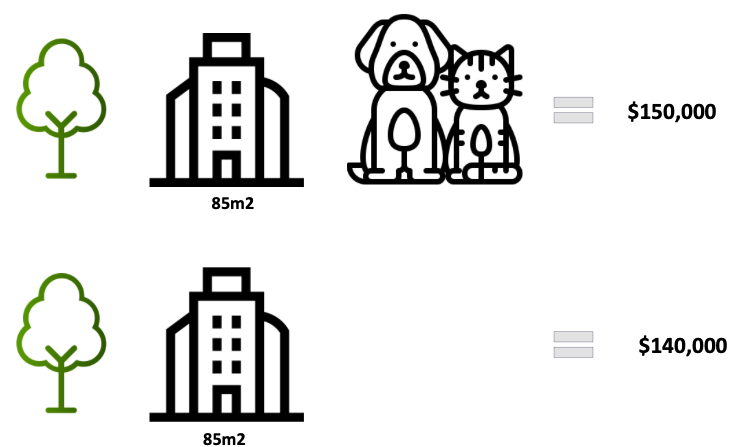

In [ ]:
Image(path[2]+'/shapley_value.png')

In [ ]:
explainer = shap.Explainer(lambda x : mlp_final.predict_log_proba(x)[:,1], X_validation)
shap_values = explainer(X_validation)

divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero

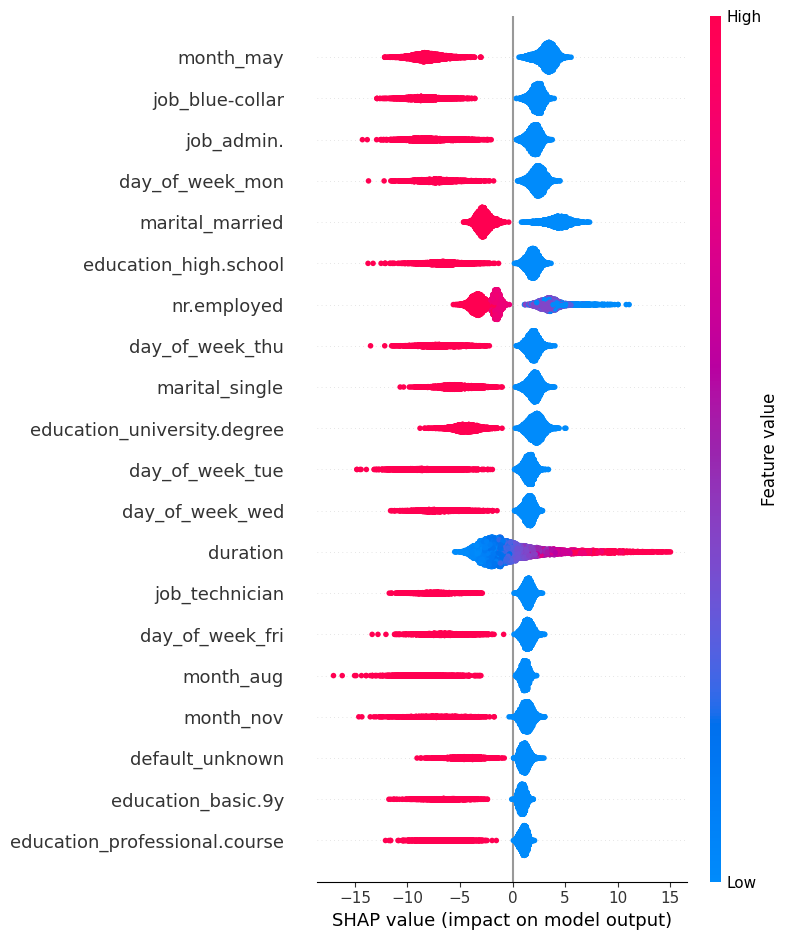

In [ ]:
shap.summary_plot(shap_values, X_validation)